In [1]:
import pandas as  pd

feature_name_df = pd.read_csv('./datasets/human_activity/features.txt' , sep="\s+", header=None , names=['column_index', 'column_name'])

In [2]:
feature_name_df.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [12]:
feature_name = feature_name_df.iloc[: ,1].values.tolist()

In [13]:
len(feature_name)

561

In [17]:
pd.read_csv('./datasets/human_activity/train/X_train.txt', sep="\s+").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7351 entries, 0 to 7350
Columns: 561 entries, 2.8858451e-001 to -5.8626924e-002
dtypes: float64(561)
memory usage: 31.5 MB


In [8]:
feature_name[:10]

['fBodyGyro-energy()-Y',
 'tBodyAccJerk-arCoeff()-Y,1',
 'fBodyAcc-mad()-Z',
 'fBodyGyro-mad()-Z',
 'fBodyGyro-kurtosis()-Z',
 'tGravityAcc-arCoeff()-X,3',
 'fBodyAccMag-entropy()',
 'tGravityAccMag-energy()',
 'tBodyGyroJerk-arCoeff()-Z,3',
 'tBodyGyro-mad()-Y']

In [18]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():
    feature_name_df = pd.read_csv('./datasets/human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    X_train = pd.read_csv('./datasets/human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./datasets/human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('./datasets/human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./datasets/human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

column_index    42
dtype: int64


In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [22]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print(round(accuracy,4))
print('DecisionTreeClassifier 기본 하이퍼파라미터:', dt_clf.get_params())

0.8548
DecisionTreeClassifier 기본 하이퍼파라미터: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [31]:
from sklearn.tree import export_graphviz
# export_graohviz() 호출결과로 out_file로 지정된 tree.dot파일 생성
export_graphviz(dt_clf,out_file="human_tree.dot",class_names=["1","2","3","4","5","6"],
               feature_names=feature_name,impurity=True,filled=True)

import graphviz

with open('human_tree.dot') as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)

In [33]:
graph.render(filename='humanity_tree_img', directory='./', format='png')

'humanity_tree_img.png'

In [38]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
         }

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: ',round(grid_cv.best_score_, 4))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치:  0.8513
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}


In [39]:
best_dt = grid_cv.best_estimator_

In [40]:
result= best_dt.predict(X_test)
best_accuracy = accuracy_score(y_test, result)
best_accuracy

0.8574821852731591

In [42]:
grid_cv.cv_results_

{'mean_fit_time': array([2.93888183, 4.42604818, 5.14432726, 5.7881566 , 6.87992878,
        6.47109914, 6.66349778]),
 'std_fit_time': array([0.41953586, 0.20070407, 0.22398381, 0.28035913, 0.9461967 ,
        0.55900781, 0.47685394]),
 'mean_score_time': array([0.01357031, 0.02493196, 0.0144702 , 0.02096338, 0.01974959,
        0.01734571, 0.01947451]),
 'std_score_time': array([0.0013548 , 0.00769797, 0.00440514, 0.00764006, 0.00480985,
        0.00495256, 0.00399767]),
 'param_max_depth': masked_array(data=[6, 8, 10, 12, 16, 20, 24],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 6},
  {'max_depth': 8},
  {'max_depth': 10},
  {'max_depth': 12},
  {'max_depth': 16},
  {'max_depth': 20},
  {'max_depth': 24}],
 'split0_test_score': array([0.81373215, 0.82053025, 0.79945615, 0.79469748, 0.79945615,
        0.8028552 , 0.7960571 ]),
 'split1_test_score': array([0.87287559, 0.81985044, 0.

In [37]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
         }

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 , refit=False)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: ',round(grid_cv.best_score_, 4))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits



KeyboardInterrupt



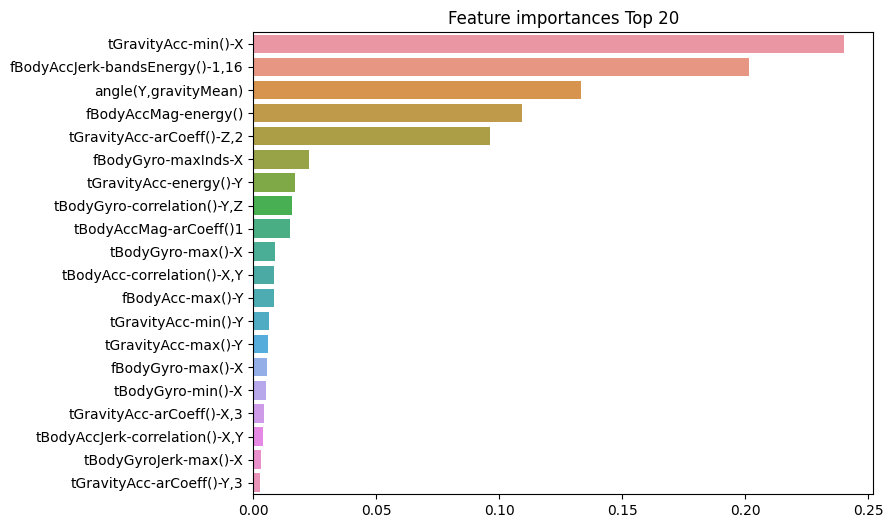

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

ftr_importances_values = best_dt.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()